<a href="https://colab.research.google.com/github/EC-520-Deep-Learning-Project/ArtStyleDetector/blob/main/tests/ResultsTesting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initializations

In [2]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/gdrive')

#imports
import numpy as np
import os
import h5py
import math
import matplotlib.pyplot as plt
import sklearn as sk
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import glob
import random
import torchvision
import torchvision.models as models
import torch.optim as optim
from tabulate import tabulate
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from torchsummary import summary

Mounted at /content/gdrive


In [3]:
#Directory Info
# %%capture
%cd '.'
%pwd
%cd 'gdrive/Shareddrives/520 Project/Data/wikipaintings_full'
%ls 


/content
/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full
wikipaintings_test/  wikipaintings_train/  wikipaintings_val/


In [42]:
ART_DIR = '/content/gdrive/Shareddrives/520 Project/Data/wikipaintings_full'

In [13]:
j = ART_DIR+'/wikipaintings_test/'
art_styles = [ style for style in os.listdir(ART_DIR+'/wikipaintings_test') if os.path.isdir(os.path.join(j, style)) ]
art_styles = sorted(art_styles)


# Resnet18 Testing

In [52]:
# Initial Setup
batch_size = 64
#training data

#get right shape and normalize
transform = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 

#Full Datasets
train_dataset = torchvision.datasets.ImageFolder(ART_DIR+'/wikipaintings_train',transform = transform)
test_dataset = torchvision.datasets.ImageFolder(ART_DIR+'/wikipaintings_test',transform = transform)
# trainloader = torch.utils.data.DataLoader(train_dataset,batch_size = batch_size,shuffle = True, num_workers = 2) 
# testloader = torch.utils.data.DataLoader(test_dataset,batch_size = batch_size,shuffle = True, num_workers = 2) 

#using a subset to test on 
indices = np.arange(len(train_dataset))
train_indices, test_indices = train_test_split(indices, train_size=100*len(art_styles), stratify=train_dataset.targets)
train_datasetsmall = torch.utils.data.Subset(train_dataset, train_indices)
test_datasetsmall = torch.utils.data.Subset(train_dataset, test_indices)
small_train = torch.utils.data.DataLoader(train_datasetsmall, shuffle=True, num_workers=2, batch_size=batch_size)
small_test = torch.utils.data.DataLoader(train_datasetsmall, shuffle=False, num_workers=2, batch_size=batch_size)


#Run on GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#Initializing a pretrained resnet
resnet18 = models.resnet18(pretrained = True)
resnet18 = resnet18.cuda() if device else resnet18

#updating last layer of the resnet to have the correct number of classifcation nodes
resnet18.to(device)
resnet18.fc = torch.nn.Linear(resnet18.fc.in_features,len(art_styles))
resnet18.fc = resnet18.fc.cuda()




In [75]:

print(len(art_styles))
print(len(small_train.dataset))
print(len(small_test.dataset))
# for style in art_styles:
#   file_count = sum(len(files) for _, _, files in os.walk(j+'/'+style))
#   print(file_count)

#Freeze all but last layer 
for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc.weight.requires_grad = True
resnet18.fc.bias.requires_grad = True

# Loss Criteria and optimization
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, resnet18.parameters()),lr = .0001, momentum = .9)

# for name, param in resnet18.named_parameters():
#     print(name, param.requires_grad)

25
2500
2500


In [113]:
# Retraining resnet with new layer

Epochs = 5
valid_loss_min = np.Inf
train_loss = []
train_acc = []
for epoch in range(1, Epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    loss_acc = 0
    for batch_idx, (images, target_) in enumerate(small_train):
        images, target_ = images.to(device), target_.to(device)
    
        outputs = resnet18(images)
        loss = criterion(outputs, target_)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))
    train_loss.append(loss)

Epoch 1: Loss = 20.41
Epoch 2: Loss = 20.25
Epoch 3: Loss = 20.11
Epoch 4: Loss = 19.97
Epoch 5: Loss = 19.87


In [115]:
#All class predictions and labels
correct = np.zeros(len(art_styles)) 
counts = np.zeros(len(art_styles))
total_pred = torch.zeros(len(small_test.dataset))
total_labels = torch.zeros(len(small_test.dataset))
with torch.no_grad():
  for idx, (images, labels) in enumerate(small_test):
    images, labels = images.cuda(), labels.cuda()
    output = resnet18(images).cpu()
    preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()
    l = labels.cpu().numpy()
    comp = l == preds
    
    for i in range(l.size):
      total_pred[i+i*idx] = l[i]
      total_labels[i+i*idx] = preds[i]
      if comp[i] == True:
        correct[l[i]] +=1
      counts[l[i]]+=1
    



In [147]:
#Plotting the Loss
# plt.figure(figsize = (15,8))
# plt.title('Training Loss')
# plt.plot(train_loss)
# plt.xlabel("Iterations")
# plt.ylabel("Loss")
# plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision, Recall and Accuracy for All Classes:

                              precision    recall  f1-score   support

                Abstract_Art       0.99      1.00      1.00      1531
      Abstract_Expressionism       0.00      0.00      0.00         0
                Art_Informel       0.00      0.00      0.00         0
        Art_Nouveau_(Modern)       0.21      0.28      0.24        36
                     Baroque       0.13      0.32      0.19        22
        Color_Field_Painting       0.00      0.00      0.00         0
                      Cubism       0.00      0.00      0.00         0
           Early_Renaissance       0.00      0.00      0.00         0
               Expressionism       0.48      0.27      0.35       114
            High_Renaissance       0.00      0.00      0.00         0
               Impressionism       0.78      0.36      0.49       328
               Magic_Realism       0.00      0.00      0.00         0
Mannerism_(Late_Renaissance)       0.00 

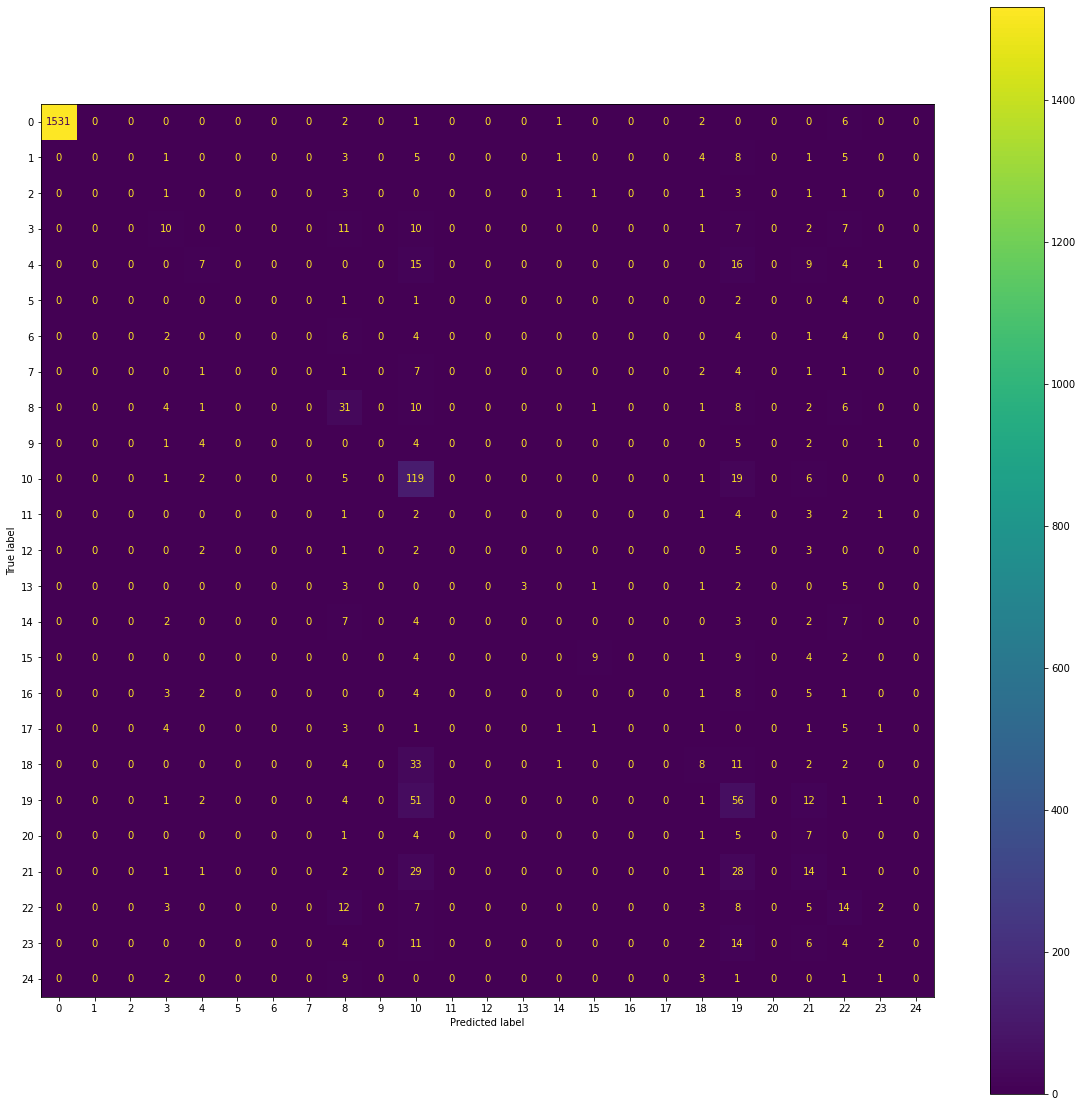

In [146]:
#Calculating results for given labels and predictions
Calc_Results(total_labels,total_pred,art_styles, by_class = False)


In [112]:
print(loss)

tensor(2.6591, device='cuda:0', grad_fn=<NllLossBackward0>)


In [84]:
print('Overall model accuracy:',int(100*sum(total_pred == total_labels)/len(total_pred)),'percent.')

Overall model accuracy: 71 percent.


#Result Calculations

In [145]:
def Calc_Results(labels,predictions,art_style, by_class = False):
  """
  Takes in model predictions,labels,loss and categories, calculates and displays:
  F-score
  Accuracy (overall and by class)
  Precision
  Recall (overall and by class)
  Can optionally request accuracy information by class
  """
  #Confusion matrix and overall model accuracy
  conf_mat = confusion_matrix(predictions,labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  fig, ax = plt.subplots(figsize=(20,20))
  disp.plot(ax = ax)

  #Precision Recall F1 score and Accuracy
  class_report = classification_report(labels,predictions,target_names =art_style)
  print('\033[1m'+'Precision, Recall and Accuracy for All Classes:\n')
  print(class_report)

  #Table of accuracy info by class
  col_names = ["Art Style","Accuracy"]
  class_acc = confusion_matrix(labels,predictions,normalize = "true").diagonal()
  # print(class_acc)
  combined_list = list(zip(art_style,class_acc))
  print('Accuracy by Class')
  print(tabulate(combined_list, headers = col_names,tablefmt="fancy_grid"))

# art_styles = ["Abstract_Expressionism","Baroque","Color_file_Painting","Minimalism"]
# num_batches = 20
# batch_size = 8
# num_styles = len(art_styles)
# loss = np.arange(num_batches*batch_size, 0, -1)
# lab = torch.zeros(num_batches*batch_size)
# images = []
# for style in range(len(art_styles)):
#   for j in range(batch_size):
#     pathtofile = ART_DIR+style
#     images[]
# #fake output
# fake_output = torch.normal(0,5, size=(batch_size, num_styles))
# pred = fake_output.data.max(1,keepdim = True)[1].squeeze(1)
# #Fake labels
# rand_label = torch.rand(batch_size, num_styles)
# percentage = torch.topk(rand_label, 1, largest = False)[0][:,-1:]
# bool_tensor = rand_label <= percentage
# label = torch.where(bool_tensor,torch.tensor(1),torch.tensor(0))
# label = label.nonzero(as_tuple = True)[1]

# Calc_Results(label,pred,loss,art_styles)






In [ ]:
# class load_wikiart:
#   def __init__(self,root,split,alter):
#     is_train = (split == 'train')
#     self.split = split
#     if alter == True:
#       self.transform = torch.nn.Sequential([
#                                       transforms.ToTensor(),
#                                       transforms.AutoAugmentPolicy()
#       ])
#     else:
#       self.transform = transforms.ToTensor()




#Other random stuff

In [ ]:
#Generating fake results until actual results are available
num_batches = 100
batch_size = 8
num_styles = 3 


# fake_output = torch.rand(batch_size,num_styles)
fake_output = torch.normal(0,5, size=(batch_size, num_styles))

print(fake_output)

rand_label = torch.rand(batch_size, num_styles)
percentage = torch.topk(rand_label, 1, largest = False)[0][:,-1:]
bool_tensor = rand_label <= percentage
label = torch.where(bool_tensor,torch.tensor(1),torch.tensor(0))
label = label.nonzero(as_tuple = True)[1]

# print(label)

pred = fake_output.data.max(1,keepdim = True)[1].squeeze(1)
print(pred)

pred = fake_output.data.max(1,keepdim = True)[1].squeeze(1)

comp = pred == label


tensor([[-1.6896,  2.1531, -7.9668],
        [-2.6251,  0.3695, -4.8277],
        [-2.5006,  8.6889, -8.9617],
        [-6.2736,  9.4651, -3.0576],
        [ 0.8470,  0.2628, -0.9315],
        [-2.9141,  8.0756, -4.8639],
        [ 4.7803, -0.1966, -1.4706],
        [-0.7242,  1.7380,  3.5039]])
tensor([1, 1, 1, 1, 0, 1, 0, 2])


In [ ]:
def calc_confusion(pred,label):
  #Takes as input the predicted labels and true labels
  #returns confusion matrix and accuracy information in that order

  
  conf_mat = confusion_matrix(pred, label)
  accuracy = np.sum(conf_mat.diagonal())/np.sum(conf_mat)
  
  return conf_mat,accuracy


(array([[1, 0, 3],
        [1, 2, 1],
        [0, 0, 0]]), 0.375)

In [ ]:
def confusion_results(conf_mat):
  #Takes confusion matrix as input, displays the confusion matrix and displays class information
  disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
  disp.plot()
  
  #Overall Model Accuracy
  accuracy = np.sum(conf_mat.diagonal())/np.sum(conf_mat)

  print('Overall Model Accuracy: 'accuracy)

  conf_mat_norm = confusion_matrix(pred,label,normalize = "true").diagonal()

  #Print table of overall 
  
  sklearn.metrics.precision_recall_fscore_support()




In [ ]:
num_batches = 20
batch_size = 8
num_styles = 3 
accuracy = []
conf_mat = torch.zeros(3,3)
correct = torch.zeros(num_styles)
counts = torch.zeros(num_styles)
all_labels = np.zeros(num_batches*batch_size)
all_predictions = np.zeros(num_batches*batch_size)

for i in range(num_batches):
  #Fake output
  fake_output = torch.normal(0,5, size=(batch_size, num_styles))
  pred = fake_output.data.max(1,keepdim = True)[1].squeeze(1)
  #Fake labels
  rand_label = torch.rand(batch_size, num_styles)
  percentage = torch.topk(rand_label, 1, largest = False)[0][:,-1:]
  bool_tensor = rand_label <= percentage
  label = torch.where(bool_tensor,torch.tensor(1),torch.tensor(0))
  label = label.nonzero(as_tuple = True)[1]
  comp = label == pred

  #Confusion Matrix
  for i in range(len(label)):
    all_labels[i+batch_size*i] = label[i]
    all_predictions[i+batch_size*i] = pred[i]
  for i in range(len(label)):
      if comp[i] == True:
        correct[label[i]] +=1
      counts[label[i]]+=1
  # accuracy[i] = acc
print(all_labels.size)
j = calc_confusion(correct,counts)

160


In [80]:

#Get Each Style From The Specified Data Folder

# class wikiartdata(Dataset):
#   def __init__(self,root,transform):
#     self.root = rootself.transform = transform

# train_split = .8
# test_split = 1-train_split


batch_size = 64




def load_wikiart(root,batch_size,tvt):
  #Takes in folder where images are stored, returns images as tensors
  #with class labels according to folder names
  #tvt is train validation test
  #Alter parameter can apply random transformations to images 
  if tvt == 'train' or 'Train':
    dir_add = '/wikipaintings_train'
  elif tvt == 'test' or 'Test':
    dir_add = '/wikipaintings_test'
  else:
    dir_add = '/wikipaintings_val'

  transform = transforms.Compose([
      transforms.Resize([256,256]),
      transforms.ToTensor()]) 

  dataset = torchvision.datasets.ImageFolder(root+dir_add,transform = transform)
  data_loader = torch.utils.data.DataLoader(dataset,batch_size = batch_size, shuffle = True)
  return data_loader


train_loader = load_wikiart(ART_DIR,batch_size,tvt = 'train')
validation_loader = load_wikiart(ART_DIR,batch_size,tvt = 'valid')
test_loader = load_wikiart(ART_DIR,batch_size,tvt = 'test')


# indices = list(range(len(dataset)))

# train_idx = indices[:int(len(indices)*train_split)]
# test_idx = indices[int(len(indices)*train_split):]

# train_split = SubsetRandomSampler(train_idx)
# test_split = SubsetRandomSampler(test_idx)


# train_loader = torch.utils.data.DataLoader(dataset,batch_size = batch_size,shuffle = True, sampler = train_split,num_workers = 2)
# test_loader = torch.utils.data.DataLoader(dataset,batch_size = batch_size,shuffle = True, sampler = test_split,num_workers = 2)


['Abstract_Art', 'Abstract_Expressionism', 'Art_Informel', 'Art_Nouveau_(Modern)', 'Baroque', 'Color_Field_Painting', 'Cubism', 'Early_Renaissance', 'Expressionism', 'High_Renaissance', 'Impressionism', 'Magic_Realism', 'Mannerism_(Late_Renaissance)', 'Minimalism', 'Naïve_Art_(Primitivism)', 'Neoclassicism', 'Northern_Renaissance', 'Pop_Art', 'Post-Impressionism', 'Realism', 'Rococo', 'Romanticism', 'Surrealism', 'Symbolism', 'Ukiyo-e']


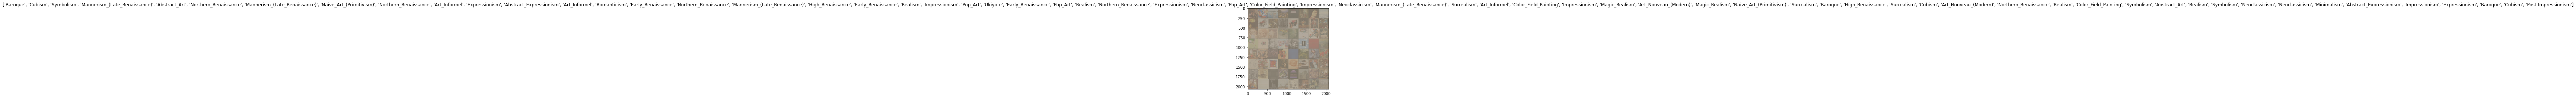

In [81]:
#Checking if stuff came out right

data_iter = iter(train_loader)
x_fixed, _ = next(data_iter)
from torchvision.transforms import ToPILImage
to_img = ToPILImage()

to_img(x_fixed[6])



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]